In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.integrate import quad
from scipy.stats import gamma
import scipy.special as sc
from functions import *

Considering a simple circle graph with equal weight, we can simply choose any of the nodes as the source node by symmetry.

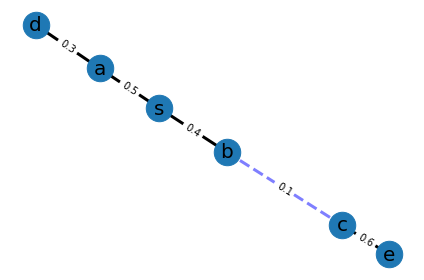

In [2]:
G = nx.Graph()
G.add_nodes_from(["s", "a", "b", "c", "d", "e"])
G.add_edge("s", "a", weight=0.5)
G.add_edge("s", "b", weight=0.4)
G.add_edge("a", "d", weight=0.3)
G.add_edge("b", "c", weight=0.1)
G.add_edge("c", "e", weight=0.6)

draw_graph(G)

The source node by randomly choosing is d.
The most possible child is a
The parent canditates are ['d']
{'d': 1.0000000000000002}
The most possible child is s
The parent canditates are ['a']
{'a': 0.5547512835681867}
The most possible child is b
The parent canditates are ['s']
{'s': 1.080000000021779}
The most possible child is c
The parent canditates are ['b']
{'b': 0.6855066029636456}
The most possible child is e
The parent canditates are ['c']
{'c': 0.13427927337753998}


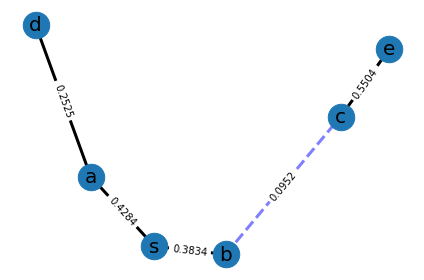

In [3]:
# Initialization 
s = np.random.choice(G.nodes()) # Randomly choose the source node for building the GGT. 
# s = 's'
print(f'The source node by randomly choosing is {s}.')
I = [s]
# Note the source here is not the same as that in rumor source detection.
# Initialize the Gamma dist parameter for the source node and calculate E and Var.
k_s = 1
theta_s = 1
E_s = k_s * theta_s
V_s = k_s * theta_s**2
# Build the GGT as T
T = nx.Graph()
T.add_node(s) # Add node s as the first parent node.
# Create a dictionary for storing the values related to each node.
k = {s:k_s}
theta = {s:theta_s}
E = {s:E_s}
V = {s:V_s}


while find_next_child(G, I) != None:
    moment_dict = {}
    moment2_dict = {}
    child = find_next_child(G, I)
    print(f'The most possible child is {child}')
    par_source = list(set(I) & set(G.neighbors(child)))
    print(f'The parent canditates are {par_source}')
    for par_ in find_parents(child, G, par_source):
        parents = find_parents(child, G, par_source)
        moment_dict[par_] = compute_moment(child, k, theta, 1, parents)
        moment2_dict[par_] = compute_moment(child, k, theta, 2, parents)
    print(moment_dict)
    par = min(moment_dict, key=moment_dict.get)
    k[child] =compute_k(E[par], V[par], G.get_edge_data(par, child)['weight'])
    theta[child] =compute_theta(E[par], V[par], G.get_edge_data(par, child)['weight'])
    E[child] = moment_dict[par]
    V[child] = moment2_dict[par] - moment_dict[par]**2
    I.append(child)
    T.add_edge(child, par, weight=round(compute_expectation(k[child], theta[child], k[par], theta[par]), 4))

draw_graph(T)

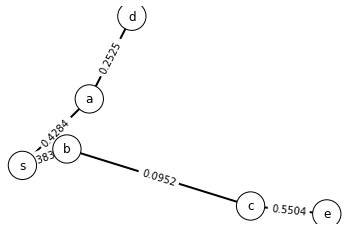

The most likely source nodes are: {'s'} 
 the corresponding likelyhood is 1.812515019964943 
 the index of the ovservation time correspond to node s  is  10


interactive(children=(IntSlider(value=1, description='index of the observation time', layout=Layout(width='500…

the darker the node color, the larger probability for the node to be the source


In [4]:
MP_weighted(T, T.nodes(), T_max=5, num_T_positions=10)